# IFT 6135 - W2019 - Assignment 1
## Question 2 - CNN for MNIST
__Assignment Instructions:__ https://www.overleaf.com/read/msxwmbbvfxrd  
__Github Repository:__ https://github.com/stefanwapnick/IFT6135PracticalAssignments  
__Developed in Python 3__  
  
__Team Members__:  
  
* Mohamed Amine (id 20150893) (Q2)
* Oussema Keskes (id 20145195) (Q3)
* Stephan Tran (id 20145195) (Q3)
* Stefan Wapnick (id 20143021) (Q1)

# Part 1 - CNN Model

###  Methodology 
A CNN model using keras and tensorflow is implemented for application on the MNIST dataset consisting of 2 series of convolutional and max pooling layers. A final dense and softmax layer for classification terminate the CNN. The following sections further describe the methodology followed for data preprocessing and hyper-parameter tuning.

In [4]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten,  MaxPooling2D, Conv2D
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizers import sgd
import matplotlib.pyplot as plt
import pandas as pd

### Data Preprocessing
The MNIST dataset is loaded. This dataset consists of 10 classes (digits) and 28x28 input images (or equivalently a 784 1d vector). Labels are one-hot encoded. The standard train/dev/test split of 50k/10k/10k recommended in the assignment 1 started code was used.

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(10000, 28, 28, 1).astype('float32') / 255
n_classes = 10
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/6, random_state=1)

print("Size of:")
print("- Training-set:\t\t{}".format(x_train.shape[0]))
print("- Validation-set:\t{}".format(x_val.shape[0]))
print("- Test-set:\t\t{}".format(x_test.shape[0]))
print(" Shape of train target set:{}".format(y_train.shape))

Size of:
- Training-set:		50000
- Validation-set:	10000
- Test-set:		10000
 Shape of train target set:(50000, 10)


###  Hyperparameter Search
Hyper-parameters are briefly tuned on the validation dataset for model selection. The training and validation accuracies and losses are reported. The following parameters are tested:

| Parameter | Value   |
|------|------|
|   learning rate  | 0.05, 0.01|
|   batch size  | 128, 256|
|   layer dimensions (conv1, conv2, dense)  | (128, 256, 64), (64, 150, 128)|


In [6]:
def create_model(learning_rate=0.001, layer_dims=[128, 256, 64]):
    model = Sequential()
    model.add(Conv2D(layer_dims[0], kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(layer_dims[1], kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(layer_dims[2], activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=sgd(lr=learning_rate), metrics=['accuracy'])
    return model

In [7]:
batch_sizes = [128, 256]
learning_rates = [0.05, 0.01]
layer_dims = [[128, 256, 64], [64, 150, 128]]
params = [(batch, alpha, dims) for batch in batch_sizes for alpha in learning_rates for dims in layer_dims]
best_model = None

print("\nHyper-Parameter Search:")
for (batch_size, learning_rate, dims) in params:
    model = create_model(learning_rate, dims)
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=10, verbose=0, validation_data=(x_val, y_val))
    print("Batch_size=%d, learning_rate=%f, dims=%s, val-acc=%f" % (batch_size, learning_rate, dims, history.history['val_acc'][-1]))
    if best_model is None or history.history['val_acc'][-1] > best_model[0].history['val_acc'][-1]:
        best_model = (history, model, (batch_size, learning_rate, dims))

history, model, stats = best_model
print("\nBEST MODEL: Batch_size=%d, learning_rate=%f, dims=%s, val-acc=%f" % (*stats, history.history['val_acc'][-1]))
print(pd.DataFrame(history.history))
model.summary()



Hyper-Parameter Search:
Batch_size=128, learning_rate=0.050000, dims=[128, 256, 64], val-acc=0.986400
Batch_size=128, learning_rate=0.050000, dims=[64, 150, 128], val-acc=0.983700
Batch_size=128, learning_rate=0.010000, dims=[128, 256, 64], val-acc=0.972600
Batch_size=128, learning_rate=0.010000, dims=[64, 150, 128], val-acc=0.971500
Batch_size=256, learning_rate=0.050000, dims=[128, 256, 64], val-acc=0.980700
Batch_size=256, learning_rate=0.050000, dims=[64, 150, 128], val-acc=0.982700
Batch_size=256, learning_rate=0.010000, dims=[128, 256, 64], val-acc=0.962100
Batch_size=256, learning_rate=0.010000, dims=[64, 150, 128], val-acc=0.951500

BEST MODEL: Batch_size=128, learning_rate=0.050000, dims=[128, 256, 64], val-acc=0.986400
   val_loss  val_acc      loss      acc
0  0.140735   0.9593  0.516678  0.84516
1  0.109671   0.9664  0.116625  0.96494
2  0.083642   0.9750  0.082670  0.97522
3  0.072500   0.9766  0.066031  0.98016
4  0.073429   0.9778  0.056796  0.98298
5  0.063924   0.9801

### Plots

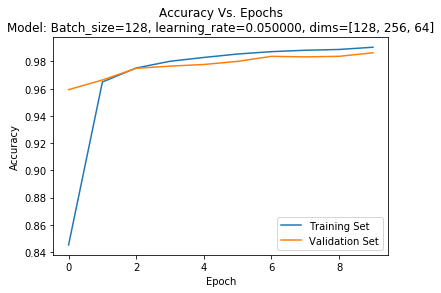

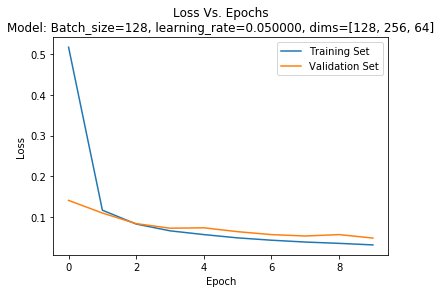

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy Vs. Epochs\nModel: Batch_size=%d, learning_rate=%f, dims=%s' % (*stats,))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Vs. Epochs\nModel: Batch_size=%d, learning_rate=%f, dims=%s' % (*stats,))
plt.ylabel('Loss')
plt.legend(['Training Set', 'Validation Set'])
plt.xlabel('Epoch')
plt.show()

### Test Set Results
Now the sequential model is evaluated using the test set. The accuracy and the loss are shown below.

In [9]:
result = model.evaluate(x_test, y_test)
print('Test Set Results:')
for name, value in zip(model.metrics_names, result):
    print(name, value)

10000/10000 [==============================] - 1s 78us/step
Test Set Results:
loss 0.03629222674376797
acc 0.9869


# Part 2 - Comparison to MLP Discussion

The CNN model achives an accuracy of approximately 1% higher than the MLP designed in question 1 (approx. 97.5% vs. 98.5%) when tested on the validation set. Although a small quantity, in the context of the MNIST dataset where overall accuracy values are high, it is significant.  
CNNs are particular adept at processing images given that the convolution operator, with various learned kernels, can be tuned to detect various patterns in an image. These patterns encoded in trained kernel weights begin as simple edges and curves but build in into more complex recognition patterns in later layers. In this way, a CNN can better analyze an image. Conversely, a MLP simply examines pixel by pixel and so is less apt at determining overall patterns.